# Import Libraries

Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

# Obtain

Read election results by county csv to results_df dataframe and filter for Donald Trump votes in 2016

In [2]:
results_df = pd.read_csv('election_results.csv')
results_df = results_df[(results_df['year'] == 2016)&(results_df['candidate'] == 'Donald Trump')]
results_df.head()

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
40518,2016,Alabama,AL,Autauga,1001.0,President,Donald Trump,republican,18172.0,24973,20191203
40521,2016,Alabama,AL,Baldwin,1003.0,President,Donald Trump,republican,72883.0,95215,20191203
40524,2016,Alabama,AL,Barbour,1005.0,President,Donald Trump,republican,5454.0,10469,20191203
40527,2016,Alabama,AL,Bibb,1007.0,President,Donald Trump,republican,6738.0,8819,20191203
40530,2016,Alabama,AL,Blount,1009.0,President,Donald Trump,republican,22859.0,25588,20191203


Find and drop voteless counties from results_df

In [3]:
results_df.drop(results_df[(results_df['totalvotes'] == 0)].index, inplace = True)
results_df.head()

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
40518,2016,Alabama,AL,Autauga,1001.0,President,Donald Trump,republican,18172.0,24973,20191203
40521,2016,Alabama,AL,Baldwin,1003.0,President,Donald Trump,republican,72883.0,95215,20191203
40524,2016,Alabama,AL,Barbour,1005.0,President,Donald Trump,republican,5454.0,10469,20191203
40527,2016,Alabama,AL,Bibb,1007.0,President,Donald Trump,republican,6738.0,8819,20191203
40530,2016,Alabama,AL,Blount,1009.0,President,Donald Trump,republican,22859.0,25588,20191203


Calculate Donald Trump proportion of votes by county, create 'county, state' column and drop uneeded coumns from results_df

In [4]:
results_df['voteproportion'] = results_df.apply(lambda x: x['candidatevotes']/x['totalvotes'], axis=1)
results_df['countystate'] = results_df['county'] + ' County, ' + results_df['state']
results_df['Areaname'] = results_df['county'] + ', ' + results_df['state_po']
results_df.head()

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version,voteproportion,countystate,Areaname
40518,2016,Alabama,AL,Autauga,1001.0,President,Donald Trump,republican,18172.0,24973,20191203,0.727666,"Autauga County, Alabama","Autauga, AL"
40521,2016,Alabama,AL,Baldwin,1003.0,President,Donald Trump,republican,72883.0,95215,20191203,0.765457,"Baldwin County, Alabama","Baldwin, AL"
40524,2016,Alabama,AL,Barbour,1005.0,President,Donald Trump,republican,5454.0,10469,20191203,0.520967,"Barbour County, Alabama","Barbour, AL"
40527,2016,Alabama,AL,Bibb,1007.0,President,Donald Trump,republican,6738.0,8819,20191203,0.764032,"Bibb County, Alabama","Bibb, AL"
40530,2016,Alabama,AL,Blount,1009.0,President,Donald Trump,republican,22859.0,25588,20191203,0.893348,"Blount County, Alabama","Blount, AL"


Within results_df, update duplicate county equivalent names in Virginia to specify independent cities vs. counties

In [5]:
results_df.loc[49206, 'countystate'] = 'Fairfax city, Virginia'
results_df.loc[49206, 'Areaname'] = 'Fairfax city, Va'
results_df.loc[49269, 'countystate'] = 'Roanoke city, Virginia'
results_df.loc[49269, 'Areaname'] = 'Roanoke city, Va'
results_df.loc[49266, 'countystate'] = 'Richmond city, Virginia'
results_df.loc[49266, 'Areaname'] = 'Richmond city, Va'
results_df.loc[49212, 'countystate'] = 'Franklin city, Virginia'
results_df.loc[49212, 'Areaname'] = 'Franklin city, Va'
results_df[results_df['state']=='Virginia'].groupby('countystate')['state'].count().sort_values(ascending=False).head()

countystate
York County, Virginia         1
Giles County, Virginia        1
Dinwiddie County, Virginia    1
Emporia County, Virginia      1
Essex County, Virginia        1
Name: state, dtype: int64

Read county area csv into area_df and update duplicate county equivalent names in Virginia to specify independent cities vs. counties

In [6]:
area_df = pd.read_csv('area.csv')
area_df.loc[2965, 'Areaname'] = 'Bedford city, Va'
area_df.loc[2975, 'Areaname'] = 'Fairfax city, Va'
area_df.loc[2995, 'Areaname'] = 'Roanoke city, Va'
area_df.loc[2996, 'Areaname'] = 'Richmond city, Va'
area_df.loc[2977, 'Areaname'] = 'Franklin city, Va'
area_df.groupby('Areaname')['Areaname'].count().sort_values(ascending=False).head()

Areaname
Ziebach, SD      1
Gooding, ID      1
Goochland, VA    1
Gonzales, TX     1
Goliad, TX       1
Name: Areaname, dtype: int64

Merge results_df with area_df and drop unneeded columns

In [7]:
results_df = pd.merge(results_df, area_df, how='inner', on=['Areaname', 'Areaname'])
results_df['landarea'] = results_df['LND110210D']
results_df = results_df[['countystate', 'county', 'state', 'voteproportion','landarea']]
print(results_df.shape)
results_df.head()

(3102, 5)


,countystate,county,state,voteproportion,landarea
0,"Autauga County, Alabama",Autauga,Alabama,0.727666,594.44
1,"Baldwin County, Alabama",Baldwin,Alabama,0.765457,1589.78
2,"Barbour County, Alabama",Barbour,Alabama,0.520967,884.88
3,"Bibb County, Alabama",Bibb,Alabama,0.764032,622.58
4,"Blount County, Alabama",Blount,Alabama,0.893348,644.78


Write census_format function to read census csv files into Pandas and create df with the specified columns

In [8]:
def census_format(file_name, input_column_names, output_column_names):
    df = pd.read_csv(file_name, header=[0,1])
    df['countystate'] = df['NAME']
    input_column_names.append('countystate')
    output_column_names.append('countystate')
    df = df[input_column_names]
    df.columns = output_column_names
    return df

Use census_format function to read census csv files into Pandas and create dfs

In [9]:
age_df = census_format('age.csv', ['S0101_C01_030E','S0101_C01_001E'], ['medianage','population'])
income_df = census_format('income.csv', ['S1902_C02_015E'], ['income'])
language_df = census_format('language.csv', ['S1601_C01_003E'],['nonenglish'])
unemployment_df = census_format('unemployment.csv', ['S2301_C04_001E'],['unemployment'])
education_df = census_format('education.csv', ['S1501_C02_012E'],['bachelorsdegree'])
race_df = census_format('race.csv', ['DP05_0032PE','DP05_0033PE','DP05_0034PE','DP05_0039PE','DP05_0047PE','DP05_0066PE'],['white','black','nativea','asian','pacifici','hispanic'])
veteran_df = census_format('veteran.csv', ['S2101_C03_001E'],['veteran'])
disability_df = census_format('disability.csv', ['S1810_C03_001E'],['disability%'])
industry_df = census_format('industry.csv', ['S2403_C01_006E','S2403_C01_003E','S2403_C01_004E'],['manufacturing', 'agriculture','mining'])


Merge dfs for each census csv file with results_df to create test df with all data

In [10]:
test = pd.merge(age_df, results_df, how='inner', on=['countystate', 'countystate'])
test = pd.merge(test, income_df, how='inner', on=['countystate', 'countystate'])
test = pd.merge(test, language_df, how='inner', on=['countystate', 'countystate'])
test = pd.merge(test, unemployment_df, how='inner', on=['countystate', 'countystate'])
test = pd.merge(test, education_df, how='inner', on=['countystate', 'countystate'])
test = pd.merge(test, race_df, how='inner', on=['countystate', 'countystate'])
test = pd.merge(test, veteran_df, how='inner', on=['countystate', 'countystate'])
test = pd.merge(test, disability_df, how='inner', on=['countystate', 'countystate'])
test = pd.merge(test, industry_df, how='inner', on=['countystate', 'countystate'])

# Scrub data

Update 'N' (specificying missing values) in test df to None and view overview of data with df.info

In [11]:
test.replace({'N':None},inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785 entries, 0 to 784
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   medianage        785 non-null    float64
 1   population       785 non-null    int64  
 2   countystate      785 non-null    object 
 3   county           785 non-null    object 
 4   state            785 non-null    object 
 5   voteproportion   785 non-null    float64
 6   landarea         785 non-null    float64
 7   income           785 non-null    int64  
 8   nonenglish       380 non-null    object 
 9   unemployment     777 non-null    object 
 10  bachelorsdegree  785 non-null    float64
 11  white            747 non-null    object 
 12  black            747 non-null    object 
 13  nativea          747 non-null    object 
 14  asian            747 non-null    object 
 15  pacifici         747 non-null    object 
 16  hispanic         785 non-null    float64
 17  veteran         

Scrub test df, including 1) replace missing values with column mean 2) convert object type values
to float type 3) calculate interaction features 4)transform non-linear relationships

In [12]:
test['unemployment'] = test['unemployment'].astype(float)
test['bachelorsdegree'] = test['bachelorsdegree'].astype(float)
test['white'] = test['white'].astype(float)
test['black'] = test['black'].astype(float)
test['nativea'] = test['nativea'].astype(float)
test['asian'] = test['asian'].astype(float)
test['pacifici'] = test['pacifici'].astype(float)
test['hispanic'] = test['hispanic'].astype(float)
test['bachelorsdegree'] = test['bachelorsdegree'].astype(float)
test['nonenglish'] = test['nonenglish'].astype(float)
test['mining'] = test['mining'].astype(float)
test['agriculture'] = test['agriculture'].astype(float)
test['manufacturing'] = test['manufacturing'].astype(float)

test.replace({None:np.nan},inplace=True)
test['nonengproportion'] = test['nonenglish']/test['population']
test['popdensity'] = test['population']/test['landarea']
test['veteran%'] = test['veteran']/test['population']
test['mining/capita'] = test['mining']/test['population']
test['agriculture/capita'] = test['agriculture']/test['population']
test['manufacturing/capita'] = test['manufacturing']/test['population']

test['popdensityroot'] = test['popdensity'].apply(lambda x:x**(1/10))
test['incomeroot'] = test['income'].apply(lambda x:x**(1/10))
test['medianageroot'] = test['medianage'].apply(lambda x:x**(1/10))
test['veteran%root'] = test['veteran%'].apply(lambda x:x**(1/10))
test['disability%root'] = test['disability%'].apply(lambda x:x**(1/10))
test['mining/capitaroot'] = test['mining/capita'].apply(lambda x:x**(1/10)-.35)
test['mining/capitaroot'] = test['mining/capitaroot'].replace({-.35:0})
test['agriculture/capitaroot'] = test['agriculture/capita'].apply(lambda x:x**(1/10)-.32)
test['agriculture/capitaroot'] = test['agriculture/capitaroot'].replace({-.32:0})
test['manufacturing/capitaroot'] = test['manufacturing/capita'].apply(lambda x:x**(1/10))
for col in list(test.columns):
    if test[col].dtype == 'float64':
        test[col] = test[col].replace({np.nan:test[col].mean()})

# Exploratory Data Analysis

Calculate vote proportion mean

In [13]:
print('Mean:')
test['voteproportion'].mean()

Mean:


0.5268391124599932

Calculate vote proportion median

In [14]:
print('Median:')
test['voteproportion'].median()

Median:


0.5454839299014854

Calculate vote proportion standard deviation

In [15]:
print('Standard Deviation:')
test['voteproportion'].std()

Standard Deviation:


0.14884679085896763

Create distplot of vote proportion

Text(0, 0.5, 'Frequency')

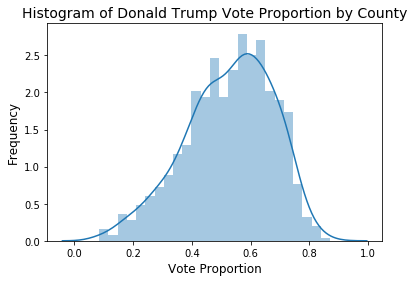

In [16]:
fig, ax = plt.subplots()
sns.distplot(test['voteproportion'], kde=True, bins=25, ax=ax)
ax.set_title('Histogram of Donald Trump Vote Proportion by County', fontsize=14)
ax.set_xlabel('Vote Proportion',fontsize=12)
ax.set_ylabel('Frequency',fontsize=12)

Plot independent variables vs. dependent variable to check for non-linear relationships

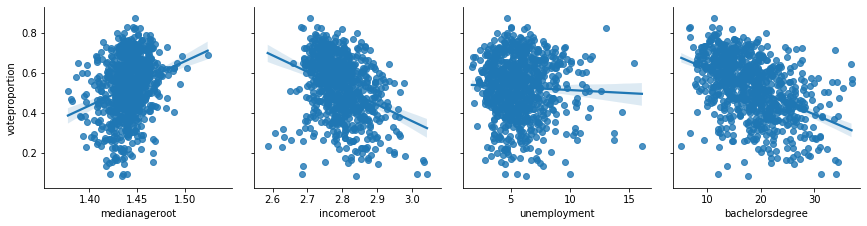

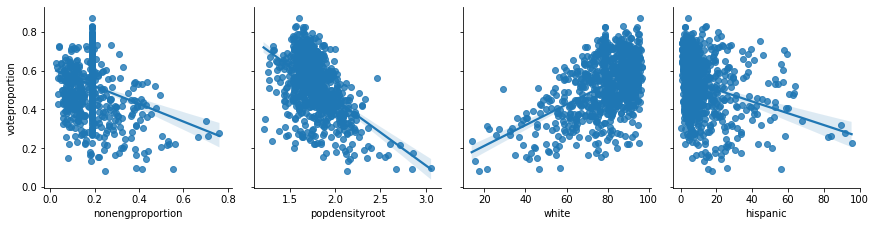

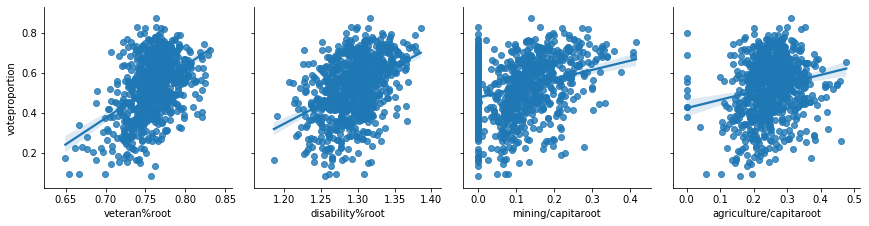

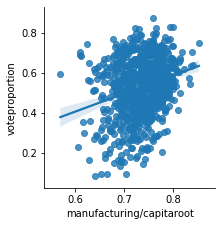

In [17]:
def pplot_features(df, features,name):
    pp_rows = [features[i:i+4] for i in range(0, len(features), 4)]
    for row in pp_rows:
        pp = sns.pairplot(data=df, y_vars=['voteproportion'], x_vars=row, kind='reg', height=3)
    return pp.savefig(name)

features = ['medianageroot','incomeroot', 'unemployment','bachelorsdegree',
            'nonengproportion','popdensityroot','white','hispanic','veteran%root',
            'disability%root','mining/capitaroot','agriculture/capitaroot',
            'manufacturing/capitaroot']
pplot_features(test, features,'rootcharts')

Calculate independent variable correlation coefficients

In [18]:
columns = ['incomeroot','medianageroot','unemployment','bachelorsdegree','white','hispanic',
           'popdensityroot','veteran%root','disability%root','manufacturing/capitaroot',
           'agriculture/capita','mining/capita']
test[columns].corr().to_csv("corr_matrix.csv")
test[columns].corr()

,incomeroot,medianageroot,unemployment,bachelorsdegree,white,hispanic,popdensityroot,veteran%root,disability%root,manufacturing/capitaroot,agriculture/capita,mining/capita
incomeroot,1.000000,0.212590,-0.502662,0.814948,0.058151,-0.135426,0.477552,-0.172059,-0.610454,-0.053655,-0.229156,-0.102791
medianageroot,0.212590,1.000000,-0.033470,-0.131718,0.322180,-0.317437,-0.095995,0.398845,0.342992,0.048629,-0.092292,-0.138682
unemployment,-0.502662,-0.033470,1.000000,-0.495721,-0.349333,0.194453,-0.153555,0.079426,0.474863,-0.224423,0.153197,0.098207
bachelorsdegree,0.814948,-0.131718,-0.495721,1.000000,-0.040121,-0.091359,0.476676,-0.302079,-0.720689,-0.107243,-0.259495,-0.127186
white,0.058151,0.322180,-0.349333,-0.040121,1.000000,-0.217198,-0.392836,0.254508,0.137685,0.276661,0.066931,0.078088
hispanic,-0.135426,-0.317437,0.194453,-0.091359,-0.217198,1.000000,0.096888,-0.360741,-0.168875,-0.350366,0.313562,0.226358
popdensityroot,0.477552,-0.095995,-0.153555,0.476676,-0.392836,0.096888,1.000000,-0.457317,-0.419029,-0.011230,-0.384192,-0.195903
veteran%root,-0.172059,0.398845,0.079426,-0.302079,0.254508,-0.360741,-0.457317,1.000000,0.499901,-0.095292,-0.014342,-0.028951
disability%root,-0.610454,0.342992,0.474863,-0.720689,0.137685,-0.168875,-0.419029,0.499901,1.000000,0.016353,0.059199,0.047104
manufacturing/capitaroot,-0.053655,0.048629,-0.224423,-0.107243,0.276661,-0.350366,-0.011230,-0.095292,0.016353,1.000000,-0.005258,-0.177587


Create heatmap of correlation coefficients

Text(69.0, 0.5, 'Feature')

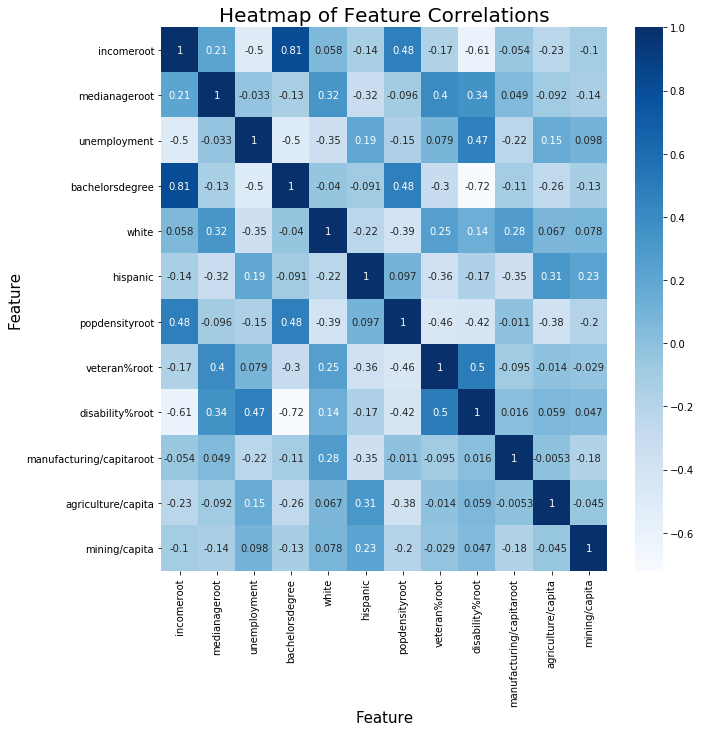

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(test[columns].corr(), cmap='Blues', ax=ax, annot=True)
ax.set_title('Heatmap of Feature Correlations', fontsize=20)
ax.set_xlabel('Feature', fontsize=15)
ax.set_ylabel('Feature', fontsize=15)


# Model data

Create x and y variables

In [21]:
x = test[columns]
y = test['voteproportion']

Perform train test split

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=38)

Standardize x variables

In [25]:
ss = StandardScaler()
ss.fit(x_train)
x_train = ss.transform(x_train)
x_test = ss.transform(x_test)
x_train = pd.DataFrame(x_train, columns = x.columns)
x_test = pd.DataFrame(x_test, columns = x.columns)
x_train.head()

,incomeroot,medianageroot,unemployment,bachelorsdegree,white,hispanic,popdensityroot,veteran%root,disability%root,manufacturing/capitaroot,agriculture/capita,mining/capita
0,0.447565,-0.940774,-0.758188,1.296024,0.069908,0.052112,1.478959,-0.346259,-0.796047,-0.080950,-0.351166,-0.292244
1,-1.448487,-1.661378,2.028520,-1.194544,-0.484550,0.470532,-1.130703,2.444002,1.574268,-1.916617,-0.138269,-0.259050
2,-0.893757,-1.065496,0.187302,0.248268,0.659458,-0.246760,-1.083941,0.385462,0.649591,-1.170474,0.104240,-0.230221
3,1.024121,-1.141124,-1.454865,2.498368,1.122677,-0.620349,-1.518293,-0.191388,-1.817129,-0.249961,1.160433,0.333293
4,1.484837,0.180222,-0.807951,0.677676,0.147111,-0.194457,0.136419,0.065224,-0.981870,-0.779078,-0.265553,-0.275742


Build dummy regressor model

In [26]:
dr = DummyRegressor()
dr.fit(x_train, y_train)
y_train_pred_dr = dr.predict(x_train)
y_test_pred_dr = dr.predict(x_test)
print('Train RMSE',np.sqrt(mean_squared_error(y_train, y_train_pred_dr)))
print('Train MAE',mean_absolute_error(y_train, y_train_pred_dr))
print('Train R2',r2_score(y_train, y_train_pred_dr))
print('Test RMSE',np.sqrt(mean_squared_error(y_test, y_test_pred_dr)))
print('Test MAE',mean_absolute_error(y_test, y_test_pred_dr))
print('Test R2',r2_score(y_test, y_test_pred_dr))

Train RMSE 0.14678640856110364
Train MAE 0.12045552966805353
Train R2 0.0
Test RMSE 0.1544837911317869
Test MAE 0.12486617756790278
Test R2 -0.0007121371104505947


Build Linear Regression model

In [27]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)
print('Train RMSE',np.sqrt(mean_squared_error(y_train, y_train_pred_lr)))
print('Train MAE',mean_absolute_error(y_train, y_train_pred_lr))
print('Train R2',r2_score(y_train, y_train_pred_lr))
print('Test RMSE',np.sqrt(mean_squared_error(y_test, y_test_pred_lr)))
print('Test MAE',mean_absolute_error(y_test, y_test_pred_lr))
print('Test R2',r2_score(y_test, y_test_pred_lr))

Train RMSE 0.09566350958450395
Train MAE 0.07650426501147965
Train R2 0.5752621835729057
Test RMSE 0.0978395236967071
Test MAE 0.07900295455708149
Test R2 0.5986049715040643


Perform gridsearch on svr model

In [28]:
svr_params = {'C': [x/100 for x in range(100,106)], 'epsilon': [x/10000 for x in range(1050,1151)]}
svr_gs_model = SVR(kernel='linear')
svr_gs = GridSearchCV(svr_gs_model, svr_params, scoring = 'neg_mean_squared_error', n_jobs = -1, cv = 5, verbose = 1)
svr_gs.fit(x_train, y_train)
print(svr_gs.best_score_)
print(svr_gs.best_params_)

Fitting 5 folds for each of 606 candidates, totalling 3030 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  2.8min


-0.009793972272290218
{'C': 1.04, 'epsilon': 0.1063}


[Parallel(n_jobs=-1)]: Done 3030 out of 3030 | elapsed:  3.1min finished


Calculate evaluation metrics for top performing rbf kernel gridsearch model

In [29]:
svr = SVR(C=.303, epsilon = .021)
svr.fit(x_train, y_train)
y_train_pred_svr = svr.predict(x_train)
y_test_pred_svr = svr.predict(x_test)
print('Train RMSE',np.sqrt(mean_squared_error(y_train, y_train_pred_svr)))
print('Train MAE',mean_absolute_error(y_train, y_train_pred_svr))
print('Train R2',r2_score(y_train, y_train_pred_svr))
print('Test RMSE',np.sqrt(mean_squared_error(y_test, y_test_pred_svr)))
print('Test MAE',mean_absolute_error(y_test, y_test_pred_svr))
print('Test R2',r2_score(y_test, y_test_pred_svr))

Train RMSE 0.06404287084097922
Train MAE 0.047055547290623334
Train R2 0.8096425431164528
Test RMSE 0.09236636916213173
Test MAE 0.07248285324024044
Test R2 0.6422570581051971


Calculate evaluation metrics for top performing linear kernel gridsearch 
model

In [30]:
svr_lin = SVR(C = 1.04, epsilon = .1063, kernel = 'linear')
svr_lin.fit(x_train, y_train)
y_train_pred_svr_lin = svr_lin.predict(x_train)
y_test_pred_svr_lin = svr_lin.predict(x_test)
print('Train RMSE',np.sqrt(mean_squared_error(y_train, y_train_pred_svr_lin)))
print('Train MAE',mean_absolute_error(y_train, y_train_pred_svr_lin))
print('Train R2',r2_score(y_train, y_train_pred_svr_lin))
print('Test RMSE',np.sqrt(mean_squared_error(y_test, y_test_pred_svr_lin)))
print('Test MAE',mean_absolute_error(y_test, y_test_pred_svr_lin))
print('Test R2',r2_score(y_test, y_test_pred_svr_lin))

Train RMSE 0.09604367634169068
Train MAE 0.0774714455911262
Train R2 0.571879659927804
Test RMSE 0.09857267691220861
Test MAE 0.07937693917642835
Test R2 0.5925667848379357


Perform gridsearch on Lasso model

In [31]:
lasso_params = {'alpha': [x/10000 for x in range(0,20000)]}
lasso_gs_model = Lasso()
lasso_gs = GridSearchCV(lasso_gs_model, lasso_params, scoring = 'neg_mean_squared_error', n_jobs = -1, cv = 5, verbose = 1)
lasso_gs.fit(x_train, y_train)
print(lasso_gs.best_score_)
print(lasso_gs.best_params_)

Fitting 5 folds for each of 20000 candidates, totalling 100000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 2680 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 6680 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 10456 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 12904 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 18744 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 29144 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 41144 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 54744 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 69944 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 86744 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 100000 out of 100000 | elapsed:  7.2min finished


-0.009753128499640575
{'alpha': 0.0014}


Calculate evaluation metrics for top performing Lasso gridsearch model

In [32]:
lasso = Lasso(alpha=.0014)
lasso.fit(x_train, y_train)
y_train_pred_lasso = lasso.predict(x_train)
y_test_pred_lasso = lasso.predict(x_test)
print('Train RMSE',np.sqrt(mean_squared_error(y_train, y_train_pred_lasso)))
print('Train MAE',mean_absolute_error(y_train, y_train_pred_lasso))
print('Train R2',r2_score(y_train, y_train_pred_lasso))
print('Test RMSE',np.sqrt(mean_squared_error(y_test, y_test_pred_lasso)))
print('Test MAE',mean_absolute_error(y_test, y_test_pred_lasso))
print('Test R2',r2_score(y_test, y_test_pred_lasso))

Train RMSE 0.09584201440937518
Train MAE 0.07678392485894157
Train R2 0.5736756123395053
Test RMSE 0.09872893099280976
Test MAE 0.07969328202174311
Test R2 0.5912740622957864


Perform gridsearch on Ridge model

In [33]:
ridge_params = {'alpha': [x/100 for x in range(0,10000)]}
ridge_gs_model = Ridge()
ridge_gs = GridSearchCV(ridge_gs_model, ridge_params, scoring = 'neg_mean_squared_error', n_jobs = -1, cv = 5, verbose = 1)
ridge_gs.fit(x_train, y_train)
print(ridge_gs.best_score_)
print(ridge_gs.best_params_)

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 2680 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 6680 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 12280 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 19480 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 28280 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 38680 tasks      | elapsed:  2.1min


-0.009727399441806539
{'alpha': 33.41}


[Parallel(n_jobs=-1)]: Done 50000 out of 50000 | elapsed:  2.8min finished


Calculate evaluation metrics on top performing Ridge gridsearch model

In [34]:
ridge = Ridge(alpha=33.41)
ridge.fit(x_train, y_train)
y_train_pred_ridge = ridge.predict(x_train)
y_test_pred_ridge = ridge.predict(x_test)
print('Train RMSE',np.sqrt(mean_squared_error(y_train, y_train_pred_ridge)))
print('Train MAE',mean_absolute_error(y_train, y_train_pred_ridge))
print('Train R2',r2_score(y_train, y_train_pred_ridge))
print('Test RMSE',np.sqrt(mean_squared_error(y_test, y_test_pred_ridge)))
print('Test MAE',mean_absolute_error(y_test, y_test_pred_ridge))
print('Test R2',r2_score(y_test, y_test_pred_ridge))

Train RMSE 0.09580034200459775
Train MAE 0.0767815574461818
Train R2 0.574046266070247
Test RMSE 0.09864220733336104
Test MAE 0.07953145095539008
Test R2 0.5919917980327816


Save linear regression coefficients to a dataframe

In [39]:
lr_coef = pd.DataFrame(data=lr.coef_, columns=['Coefficient'])
lr_coef['Feature'] = x_train.columns
lr_coef = lr_coef.sort_values(by='Coefficient')
lr_coef

,Coefficient,Feature
3,-0.034861,bachelorsdegree
0,-0.026927,incomeroot
5,-0.022364,hispanic
2,-0.016588,unemployment
6,-0.011933,popdensityroot
8,-0.007539,disability%root
10,-0.003785,agriculture/capita
1,0.007735,medianageroot
9,0.014892,manufacturing/capitaroot
7,0.030374,veteran%root


Create bar chart of linear regression coefficients

Text(0.5, 1.0, 'Linear Regression Feature Importance in 2016 Election Support for Donald Trump')

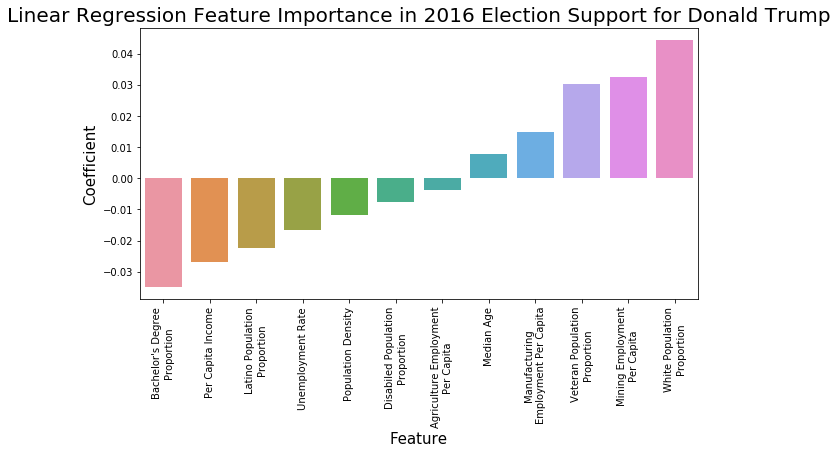

In [40]:
fig,ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Feature',y='Coefficient',data=lr_coef, estimator=np.median, ax=ax)
ax.set_xticklabels(["Bachelor's Degree\nProportion", 'Per Capita Income',  'Latino Population\nProportion', 'Unemployment Rate',
                   'Population Density', 'Disabiled Population\nProportion', 'Agriculture Employment\nPer Capita',
                   'Median Age', 'Manufacturing\nEmployment Per Capita', 'Veteran Population\nProportion', 
                    'Mining Employment\nPer Capita', 'White Population\nProportion'], 
                   rotation=90, fontsize = 10)
ax.set_xlabel('Feature', fontsize = 15)
ax.set_ylabel('Coefficient', fontsize = 15)
ax.set_title('Linear Regression Feature Importance in 2016 Election Support for Donald Trump', fontsize=20)


Save lasso coefficients to a dataframe

In [41]:
lasso_coef = pd.DataFrame(data=lasso.coef_, columns = ['Coefficient'])
lasso_coef['Feature'] = x_train.columns
lasso_coef = lasso_coef.sort_values(by='Coefficient')

lasso_coef

,Coefficient,Feature
3,-0.033589,bachelorsdegree
5,-0.021267,hispanic
0,-0.020339,incomeroot
2,-0.015447,unemployment
6,-0.012228,popdensityroot
10,-0.001973,agriculture/capita
8,-0.000000,disability%root
1,0.003480,medianageroot
9,0.014396,manufacturing/capitaroot
7,0.028632,veteran%root


Create bar chart of Lasso coefficients

Text(0, 0.5, 'Coefficient')

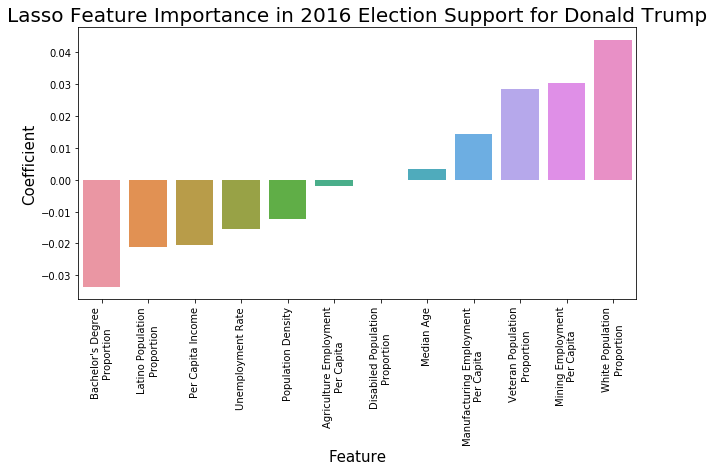

In [42]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Feature',y='Coefficient',data=lasso_coef, estimator=np.median, ax=ax)
ax.set_xticklabels(["Bachelor's Degree\nProportion",  'Latino Population\nProportion', 'Per Capita Income', 'Unemployment Rate',
                   'Population Density', 'Agriculture Employment\nPer Capita','Disabiled Population\nProportion', 
                   'Median Age', 'Manufacturing Employment\nPer Capita', 'Veteran Population\nProportion',
                    'Mining Employment\nPer Capita', 'White Population\nProportion'], rotation=90)
ax.set_title('Lasso Feature Importance in 2016 Election Support for Donald Trump', fontsize=20)
ax.set_xlabel('Feature', fontsize = 15)
ax.set_ylabel('Coefficient', fontsize = 15)